# Neural Spline Flow on a Circular and a Normal Coordinate

We aim to approximate a distribution having as circular and a normal coordinate. To construct such a case, let $x$ be the normal (unbound) coordinate follow a standard normal distribution, i.e. 
$$ p(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} x ^ 2}.$$
The circular random variable $\phi$ follows a [von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution) given by
$$ p(\phi|x) = \frac{1}{2\pi I_0(1)} e^{\cos(\phi-\mu(x))}, $$
where $I_0$ is the $0^\text{th}$ order Bessel function of the first kind and we set $\mu(x) = 3x$. Hence, our full target is given by
$$ p(x, \phi) = p(x)p(\phi|x) = \frac{1}{(2\pi)^{\frac{3}{2}} I_0(1)} e^{-\frac{1}{2} x ^ 2 + \cos(\phi-3x)}. $$
We use a neural spline flow that models the two coordinates accordingly.

## Setup

In [1]:
# Import packages
import torch
import numpy as np

import normflows as nf

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm import tqdm

This is our target $p(x, \phi)$.

In [2]:
# Set up target
class GaussianVonMises(nf.distributions.Target):
    def __init__(self):
        super().__init__(prop_scale=torch.tensor(2 * np.pi), 
                         prop_shift=torch.tensor(-np.pi))
        self.n_dims = 2
        self.max_log_prob = -1.99
        self.log_const = -1.5 * np.log(2 * np.pi) - np.log(np.i0(1))
    
    def log_prob(self, x):
        return -0.5 * x[:, 0] ** 2 + torch.cos(x[:, 1] - 3 * x[:, 0]) + self.log_const

In [3]:
target = GaussianVonMises()

C:\Users\kanha\anaconda3\envs\ml_env\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


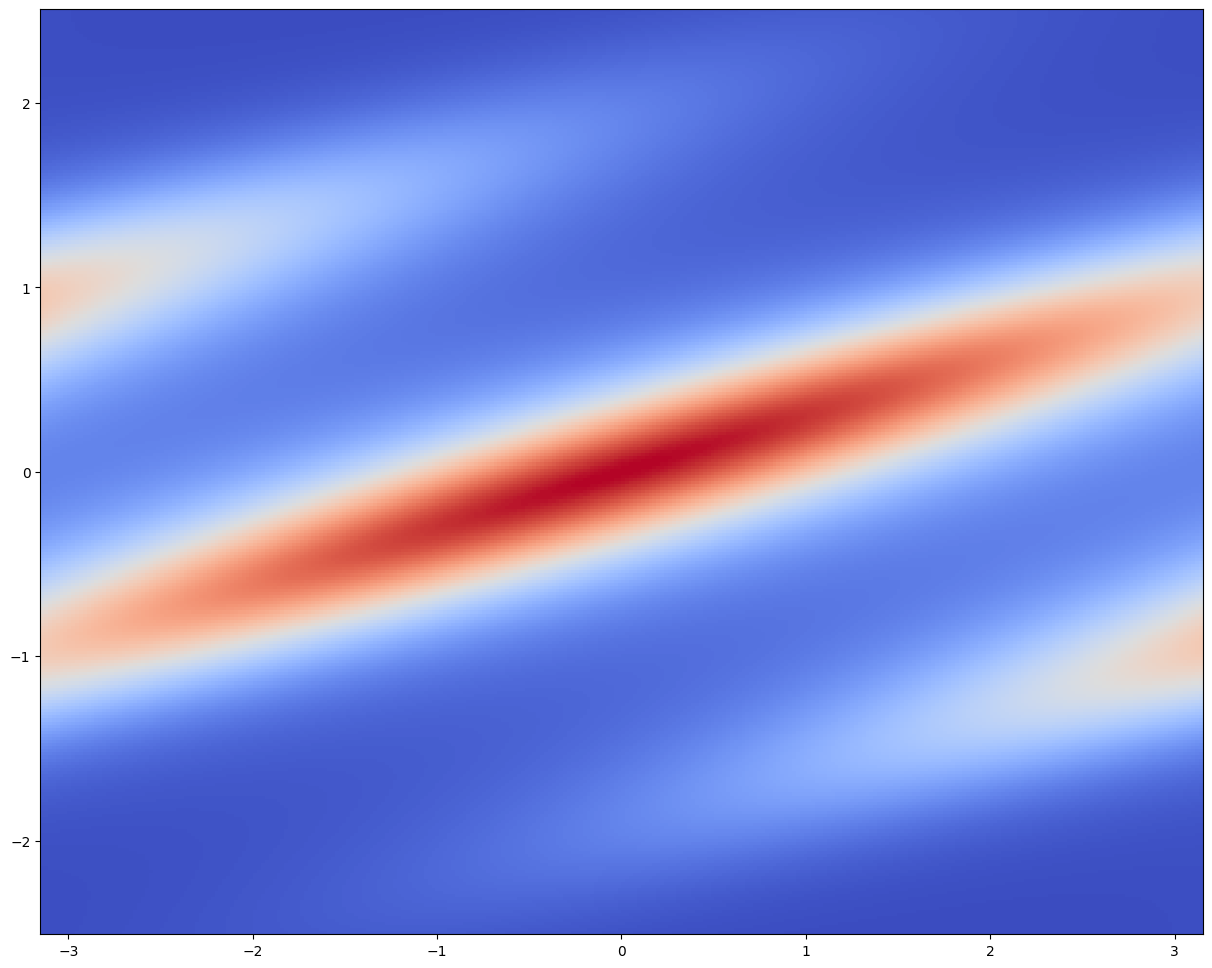

In [4]:
# Plot target
grid_size = 300
xx, yy = torch.meshgrid(torch.linspace(-2.5, 2.5, grid_size), torch.linspace(-np.pi, np.pi, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

log_prob = target.log_prob(zz).view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(yy, xx, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

In [5]:
base = nf.distributions.UniformGaussian(2, [1], torch.tensor([1., 2 * np.pi]))

K = 12

flow_layers = []
for i in range(K):
    flow_layers += [nf.flows.CircularAutoregressiveRationalQuadraticSpline(2, 1, 512, [1], num_bins=10,
                                                                           tail_bound=torch.tensor([5., np.pi]),
                                                                           permute_mask=True)]

model = nf.NormalizingFlow(base, flow_layers, target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

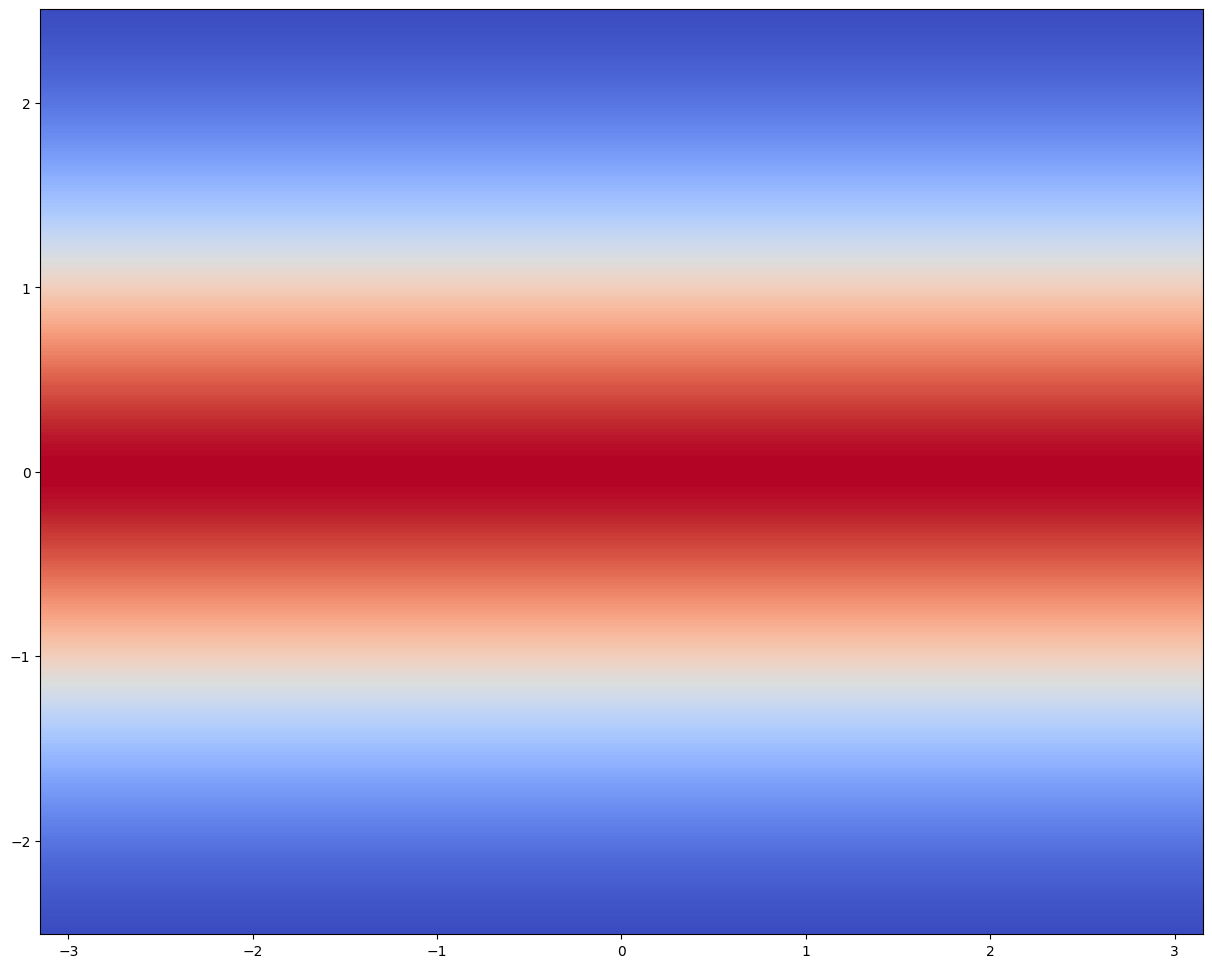

In [6]:
# Plot model
log_prob = model.log_prob(zz.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(yy, xx, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Training

In [ ]:
# Train model
max_iter = 10000
num_samples = 2 ** 14
show_iter = 2500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Compute loss
    loss = model.reverse_kld(num_samples)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned model
    if (it + 1) % show_iter == 0:
        model.eval()
        with torch.no_grad():
            log_prob = model.log_prob(zz.to(device)).to('cpu').view(*xx.shape)
        model.train()
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(yy, xx, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()
    
    # Iterate scheduler
    scheduler.step()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  7%|▋         | 697/10000 [2:50:57<40:22:49, 15.63s/it] 

## Visualization of the Results

In [ ]:
# 2D plot
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

log_prob = target.log_prob(zz).view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(yy, xx, prob.data.numpy(), cmap='coolwarm')
ax[0].set_aspect('equal', 'box')

ax[0].set_xticks(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax[0].set_xticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', '$\pi$'],
                      fontsize=20)
ax[0].set_yticks(ticks=[-2, -1, 0, 1, 2])
ax[0].set_yticklabels(['$-2$', '$-1$', '$0$', '$1$', '$2$'],
                      fontsize=20)
ax[0].set_xlabel('$\phi$', fontsize=24)
ax[0].set_ylabel('$x$', fontsize=24)

ax[0].set_title('Target', fontsize=24)

log_prob = model.log_prob(zz.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(yy, xx, prob.data.numpy(), cmap='coolwarm')
ax[1].set_aspect('equal', 'box')

ax[1].set_xticks(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax[1].set_xticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', '$\pi$'],
                      fontsize=20)
ax[1].set_xlabel('$\phi$', fontsize=24)

ax[1].set_title('Neural Spline Flow', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

In [ ]:
# 3D plot
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

phi = np.linspace(-np.pi, np.pi, grid_size)
z = np.linspace(-2.5, 2.5, grid_size)

# create the surface
x = np.outer(np.ones(grid_size), np.cos(phi))
y = np.outer(np.ones(grid_size), np.sin(phi))
z = np.outer(z, np.ones(grid_size))

# Target
log_prob = target.log_prob(zz).view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

prob_vis = prob / torch.max(prob)
myheatmap = prob_vis.data.numpy()

ax1._axis3don = False
ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.coolwarm(myheatmap), shade=False)

ax1.set_title('Target', fontsize=24, y=0.97, pad=0)

# Model
log_prob = model.log_prob(zz.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

prob_vis = prob / torch.max(prob)
myheatmap = prob_vis.data.numpy()

ax2._axis3don = False
ax2.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.coolwarm(myheatmap), shade=False)

t = ax2.set_title('Neural Spline Flow', fontsize=24, y=0.97, pad=0)

plt.subplots_adjust(wspace=-0.4)

plt.show()